# Introduction

This notebook implement the pair trading based on the chat with chatGPT.
The full pdf: https://drive.google.com/file/d/1Z3DTZo1hprKuNe24vRPW6DcR4ed0j0Go/view?usp=sharing


In [22]:
import sys

sys.path.append("../")

In [41]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from pykalman import KalmanFilter

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,10)

# DATA_PATH = '/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min'
DATA_PATH = '/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/crypto/1h'

In [24]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTC', 'ETH', 'ADA', 'BNB', 'SOL', 'XRP', 'DOGE', 'DOT', 'LUNA', 'UNI', 'LINK', 'BCH', 'LTC', 'ALGO', 'AVAX', 'ICP', 'WBTC', 'FTT', 'MATIC', 'FIL', 'XLM', 'VET', 'ETC', 'TRX', 'THETA']
symbols = [f'{s}-USDT' for s in symbols]

data = []
start_date = '2021-05-01'
end_date = '2021-08-01'

for symbol in symbols:
    try:
        file = f'{DATA_PATH}/{symbol}.csv'
        # print(file)
        df = pd.read_csv(file, 
                        parse_dates=['open_time'], 
                        index_col=['open_time'])
        df = df[(df.index > start_date) & (df.index < end_date)]
        df = df[~df.index.duplicated(keep='first')]

        df.rename(columns={'close': symbol}, inplace=True)
        # the data is too long, just limit to recent period
        data.append(np.log(df[symbol]))
    except:
        pass

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
df.dropna(inplace=True, how='any')

df.tail()

,BTC-USDT,ETH-USDT,ADA-USDT,BNB-USDT,SOL-USDT,XRP-USDT,DOGE-USDT,DOT-USDT,LUNA-USDT,UNI-USDT,...,LTC-USDT,ALGO-USDT,AVAX-USDT,MATIC-USDT,FIL-USDT,XLM-USDT,VET-USDT,ETC-USDT,TRX-USDT,THETA-USDT
open_time,,,,,,,,,,,,,,,,,,,,,
2021-07-31 19:00:00,10.628536,7.806232,0.263825,5.801695,3.537998,-0.292092,-1.574795,2.798256,2.375836,3.051687,...,4.962495,-0.179845,2.556297,0.044782,3.940358,-1.258922,-2.435088,3.921676,-2.752629,1.804840
2021-07-31 20:00:00,10.633541,7.820323,0.268576,5.807181,3.550307,-0.288216,-1.570073,2.814630,2.389313,3.066657,...,4.968076,-0.170551,2.581050,0.050598,3.945303,-1.251169,-2.431101,3.932923,-2.747155,1.810908
2021-07-31 21:00:00,10.644234,7.838671,0.278389,5.821714,3.585212,-0.279185,-1.562077,2.832154,2.391603,3.084933,...,4.980726,-0.165111,2.592041,0.062693,3.951993,-1.244830,-2.411954,3.946618,-2.739851,1.814662
2021-07-31 22:00:00,10.641694,7.838237,0.279751,5.823016,3.587954,-0.283159,-1.563413,2.829796,2.389221,3.086532,...,4.980726,-0.162754,2.605205,0.083973,3.960261,-1.242887,-2.408612,3.944393,-2.739541,1.805662
2021-07-31 23:00:00,10.632198,7.836168,0.276798,5.806640,3.603349,-0.292494,-1.571612,2.819353,2.373975,3.078740,...,4.972310,-0.174949,2.606682,0.080012,3.951840,-1.256600,-2.411062,3.938840,-2.749341,1.808944


In [25]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(df, symbol_pairs):
    df_t = df[symbol_pairs].copy()

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
    # print("trace_crit_value",trace_crit_value)
    # print("eigen_crit_value",eigen_crit_value)
    # print("lr1",result.lr1)
    # print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)



In [26]:

import itertools as it

nb_symbols = 2
cointegrating_pairs = []

df1 = df[(df.index >= '2021-05-01') & (df.index <= '2021-12-01')]

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))

for pair in pairs:
    try:
        test_johansen(df1, list(pair))
    except KeyError:
        pass

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

,hedge_ratio,sid_1,sid_2
0,"[10.3247466000417, -5.257339522098885]",BTC-USDT,ETH-USDT
1,"[3.103947596341082, 3.6633523980749243]",BTC-USDT,ADA-USDT
2,"[2.5310764120628235, -6.832787011831495]",BTC-USDT,SOL-USDT
3,"[9.519732518027352, -2.5336214287417764]",BTC-USDT,LINK-USDT
4,"[12.25365437161246, -4.38646233735937]",BTC-USDT,LTC-USDT


In [27]:
coint_df.to_csv('coint_df.csv')


In [33]:
import warnings
warnings.filterwarnings("ignore")

def calculate_spread(df, selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    return spread


critical_val = 0.005

def find_stationary_portfolio(df):
    data = []
    for i, _ in coint_df.iterrows():
        selected_row = i
        hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
        spread = calculate_spread(df, selected_row, hedge_ratio)
        adf_p = adf_test(spread, verbose=False)
        pp_p = pp_test(spread, verbose=False)
        kpss_p = kpss_test(spread, verbose=False)

        if adf_p < critical_val and pp_p < critical_val and kpss_p > critical_val:
            # half_life = cal_half_life(spread)
            pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[selected_row].values
            # print(i, pairs_name, 'is stationary with half life', half_life)
            # print(' ')
            data.append({
                'i': i,
                'pairs': pairs_name,
                # 'half_life': half_life
            })
    
    return pd.DataFrame(data)


stationary_df = find_stationary_portfolio(df1)
# stationary_df.sort_values(by=['half_life'], inplace=True)
stationary_df

,i,pairs
0,6,"[BTC-USDT, ETC-USDT]"
1,15,"[ETH-USDT, ETC-USDT]"
2,25,"[BNB-USDT, ALGO-USDT]"
3,27,"[BNB-USDT, ETC-USDT]"
4,37,"[XRP-USDT, ETC-USDT]"
5,39,"[DOGE-USDT, FIL-USDT]"
6,40,"[DOGE-USDT, ETC-USDT]"
7,48,"[UNI-USDT, ETC-USDT]"
8,50,"[LINK-USDT, ETC-USDT]"
9,51,"[BCH-USDT, ETC-USDT]"


In [35]:
selected_row = stationary_df['i'].iloc[1]
hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
spread = calculate_spread(df1, selected_row, hedge_ratio)

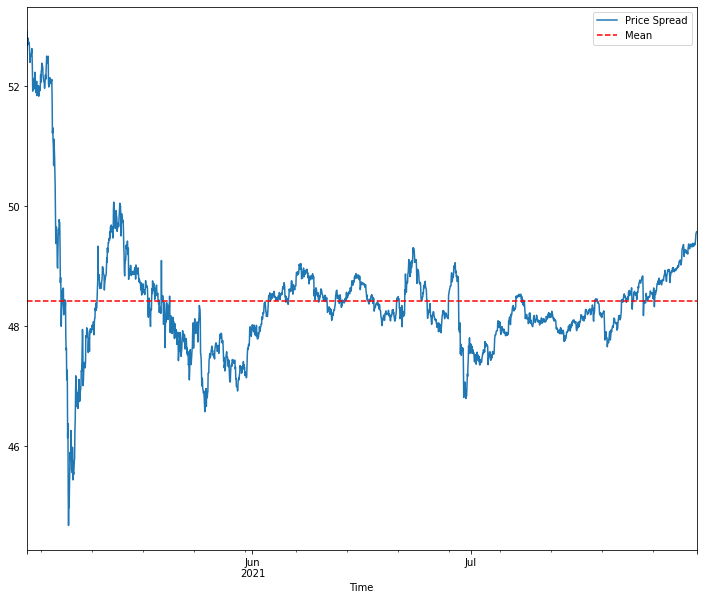

In [40]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

## Apply the kalman filter for spread

Kalman Filter: The Kalman Filter is a mathematical algorithm that can be used to estimate the state of a system based on noisy observations. This algorithm is often used in StatArb to estimate the mean and standard deviation of the spread between two instruments. Traders using this method will enter and exit trades based on the estimated mean and standard deviation.

Johansen test can be used to estimate the hedge ratio for a spread in pair trading. The Johansen test can be used to determine the cointegration relationship between two assets, which is an important aspect of pair trading. The test results can be used to determine the optimal hedge ratio between the two assets, which is then used to create a spread and establish a trade position. The hedge ratio helps to ensure that the spread remains stationary and has a low volatility, which makes it easier to generate profits from the trade.

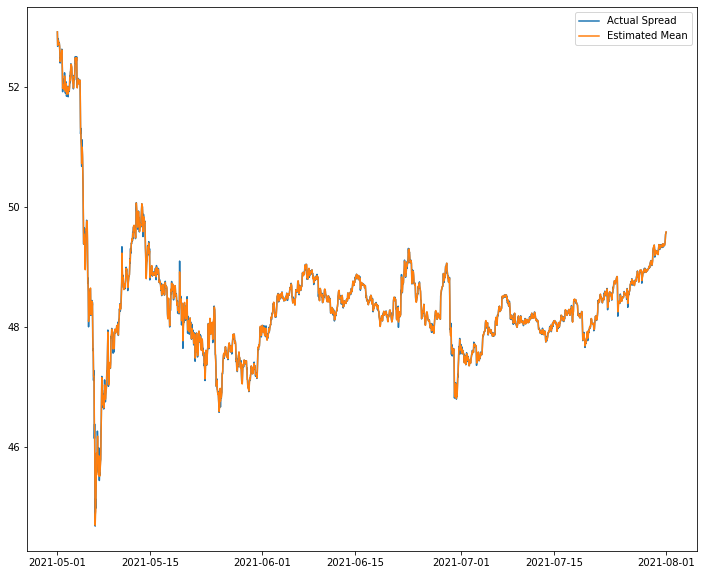

In [50]:
# Define the initial state mean and covariance matrices
initial_state_mean = [spread[0], 0]
initial_state_covariance = [[1, 0], [0, 1]]

# Define the transition matrix
transition_matrix = [[1, 1], [0, 1]]

# Define the observation matrix
observation_matrix = [1, 0]

# Define the transition covariance matrix
transition_covariance = [[0.1, 0.1], [0.1, 0.1]]

# Define the observation covariance matrix
observation_covariance = [0.1]

# Create the Kalman filter object
kf = KalmanFilter(
    transition_matrices=transition_matrix,
    observation_matrices=observation_matrix,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance,
    transition_covariance=transition_covariance,
    observation_covariance=observation_covariance
)

# Use the filter to estimate the state mean and covariance
state_means, state_covariances = kf.filter(spread.values)

# Plot the estimated mean and actual spread
plt.plot(spread, label='Actual Spread')
plt.plot(pd.Series(state_means[:,0], index=spread.index), label='Estimated Mean')
plt.legend()
plt.show()

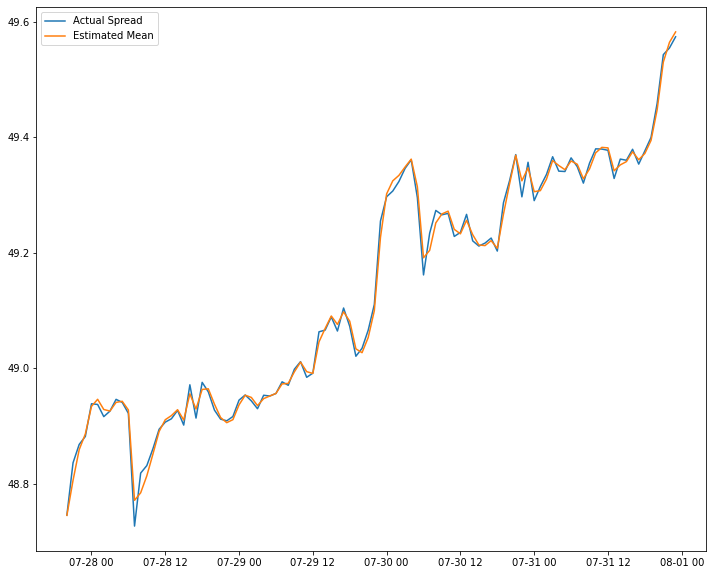

In [51]:
plt.plot(spread.tail(100), label='Actual Spread')
plt.plot(pd.Series(state_means[:,0], index=spread.index).tail(100), label='Estimated Mean')
plt.legend()
plt.show()

### Using ADF to estimate the rate of mean reversion

In [52]:
import statsmodels.tsa.stattools as ts

# perform the Augmented Dickey-Fuller test
result = ts.adfuller(spread)

# test statistic
adf_test_statistic = result[0]

# critical values at 1%, 5%, and 10% significance levels
critical_values = result[4]

# if the ADF test statistic is less than the critical value at the 1% significance level,
# we can reject the null hypothesis that the spread time series is not mean reverting
if adf_test_statistic < critical_values['1%']:
    print('Spread time series is mean reverting')
else:
    print('Spread time series is not mean reverting')

# estimate the rate of mean reversion
half_life = -np.log(2) / adf_test_statistic
print('Estimated half-life: ', half_life)


Spread time series is mean reverting
Estimated half-life:  0.1478500729440036


In [54]:
from scipy.optimize import minimize

# optimization function to minimize the sum of squared errors between the observed spread and the OU model
def optimization_function(params, spread):
    mu, alpha = params
    N = len(spread)
    errors = np.zeros(N)
    for t in range(1, N):
        errors[t] = spread[t] - (mu + (spread[t-1] - mu) * np.exp(-alpha))
    return np.sum(errors**2)

# initial guess for the optimization
initial_guess = [np.mean(spread), 0.1]

# minimize the optimization function
result = minimize(optimization_function, initial_guess, args=(spread,))

# estimated parameters
mu_est, alpha_est = result.x

# estimate the half-life
half_life = -np.log(2) / alpha_est
print('Estimated half-life: ', int(half_life))

Estimated half-life:  -66


In [63]:
half_life = cal_half_life(spread)
print('Estimated half-life: ', int(half_life))

Estimated half-life:  64


### Zscore with Kalman filter

In [65]:
def calc_zscore(spread, half_life):
    # Calculate the daily returns of the spread
    returns = np.log(spread / spread.shift(1))
    
    # Calculate the exponential moving average (EMA) of the returns
    ema = returns.ewm(halflife=half_life).mean()
    
    # Calculate the exponential moving standard deviation (EMSD) of the returns
    emsd = returns.ewm(halflife=half_life).std()
    
    # Calculate the z-score as the difference between the current spread and its EMA, divided by the EMSD
    zscore = (spread - ema) / emsd
    
    return zscore


def kalman_filter_zscore(spread, half_life):
    # Initialize the Kalman filter
    kf = KalmanFilter(
        transition_matrices=transition_matrix,
        observation_matrices=observation_matrix,
        initial_state_mean=initial_state_mean,
        initial_state_covariance=initial_state_covariance,
        transition_covariance=transition_covariance,
        observation_covariance=observation_covariance
    )

    # Perform the Kalman filter
    state_means, _ = kf.filter(spread.values)
    
    # Calculate the daily returns of the spread
    returns = np.log(spread / spread.shift(1))
    
    # Calculate the exponential moving average (EMA) of the returns
    ema = returns.ewm(halflife=half_life).mean()
    
    # Calculate the residuals as the difference between the spread and its Kalman filter estimate
    residuals = spread - state_means[:, 0]
    
    # Calculate the z-score as the difference between the residuals and its EMA, divided by the EMSD
    zscore = (residuals - ema) / ema.rolling(half_life).std()
    
    return zscore

zscore = kalman_filter_zscore(spread, half_life)
# zscore = calc_zscore(spread, half_life)
# print(zscore)

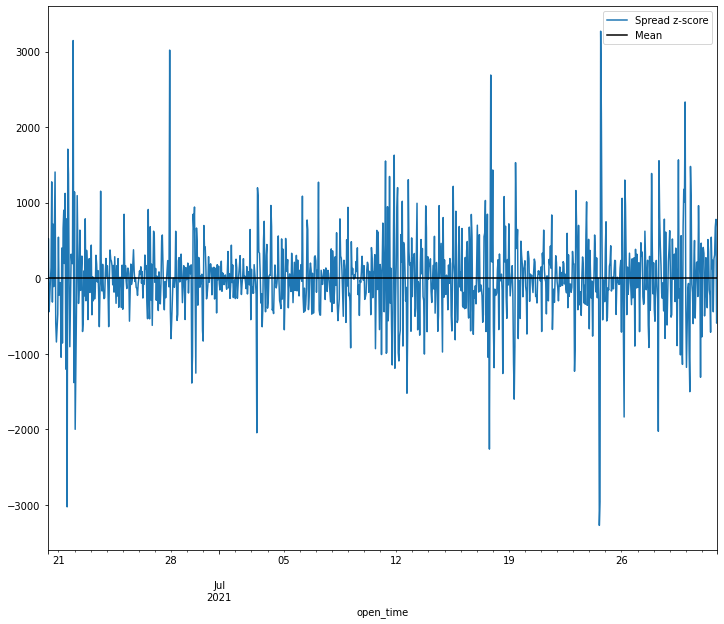

In [66]:
zscore.tail(1000).plot()
plt.axhline(zscore.tail(1000).mean(), color='black')
# plt.axhline(1.0, color='red', linestyle='--')
# plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])

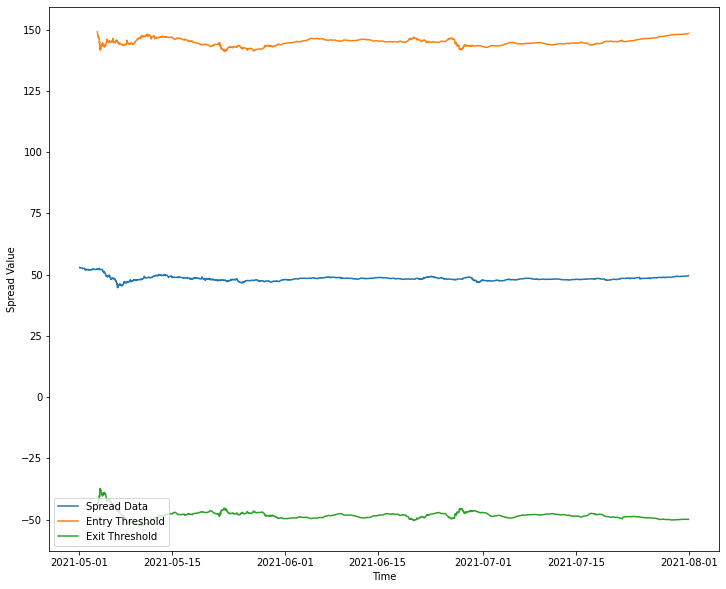

In [120]:
import numpy as np
import statsmodels.tsa.stattools as sts
from arch import arch_model
import statsmodels.graphics.tsaplots as tsa

spread_returns = np.diff(np.log(spread))

spread_volatility = [np.nan for _ in range(half_life)]

# Fit a GARCH model to the spread returns data
for i in range(half_life, len(spread)):
    model = arch_model(spread.iloc[i:i+half_life], mean='Zero', vol='GARCH', p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1).variance.values
    spread_volatility.append(np.sqrt(pred[-1][0]))

spread_volatility = pd.Series(spread_volatility, index=spread.index)

# Calculate moving average and standard deviation of the spread
spread_mean = spread.rolling(half_life).mean()
spread_std = spread.rolling(half_life).std()

# # Set dynamic thresholds for trade entry and exit
entry_threshold = spread_mean + 2 * spread_volatility
exit_threshold = spread_mean - 2 * spread_volatility

# Plot the spread data, dynamic thresholds and mean
plt.plot(spread)
plt.plot(pd.Series(np.ones(len(spread)) * entry_threshold, index=spread.index))
plt.plot(pd.Series(np.ones(len(spread)) * exit_threshold, index=spread.index))
# plt.plot(pd.Series(np.ones(len(spread)) * spread_mean, index=spread.index))
plt.xlabel('Time')
plt.ylabel('Spread Value')
plt.legend(['Spread Data', 'Entry Threshold', 'Exit Threshold', 'Spread Mean'])
plt.show()

In [121]:
spread_volatility

open_time
2021-05-01 01:00:00          NaN
2021-05-01 02:00:00          NaN
2021-05-01 03:00:00          NaN
2021-05-01 04:00:00          NaN
2021-05-01 05:00:00          NaN
                         ...    
2021-07-31 19:00:00    49.536872
2021-07-31 20:00:00    49.545163
2021-07-31 21:00:00    49.557333
2021-07-31 22:00:00    49.564362
2021-07-31 23:00:00    49.573998
Length: 2207, dtype: float64

In [122]:
spread_std

open_time
2021-05-01 01:00:00         NaN
2021-05-01 02:00:00         NaN
2021-05-01 03:00:00         NaN
2021-05-01 04:00:00         NaN
2021-05-01 05:00:00         NaN
                         ...   
2021-07-31 19:00:00    0.142563
2021-07-31 20:00:00    0.141282
2021-07-31 21:00:00    0.141952
2021-07-31 22:00:00    0.142542
2021-07-31 23:00:00    0.143817
Name: ETH-USDT, Length: 2207, dtype: float64

In [118]:

spread_mean = spread.rolling(half_life).mean()
print(len(spread_mean))
spread_std = spread.rolling(half_life).std()

print('spread_volatility', len(spread_volatility), len(spread_std))
# Set dynamic thresholds for trade entry and exit
entry_threshold = spread_mean + 2 * spread_volatility * spread_std
# exit_threshold = spread_mean - 2 * spread_volatility * spread_std

entry_threshold

2207
spread_volatility 2207 2207


open_time
2021-05-01 01:00:00          NaN
2021-05-01 02:00:00          NaN
2021-05-01 03:00:00          NaN
2021-05-01 04:00:00          NaN
2021-05-01 05:00:00          NaN
                         ...    
2021-07-31 19:00:00    63.349343
2021-07-31 20:00:00    63.232672
2021-07-31 21:00:00    63.311726
2021-07-31 22:00:00    63.381577
2021-07-31 23:00:00    63.520017
Length: 2207, dtype: float64

In [86]:
entry_threshold

array([[         nan],
       [         nan],
       [         nan],
       ...,
       [         nan],
       [         nan],
       [148.00557801]])